Goal: create maps of street networks, but only within a buffer around a geocoded place.

Next goal: functions to measure and visualize urban indicators.

Steps:
- write code to plot heatmap of point density [DONE]
- convert heatmap code to function [DONE]
- write code to clip heatmap to buffer ring [DONE]
- write code to get osm amenity data based on category

Ideas for Urban Indicators:
- intersection density (hexbin/heatmap) [DONE]
- density of x-height buildings (hexbin/heatmap)
- density of x kind of amenity (hexbin/heatmap)
    - sustenance (restaurants, bars, etc.)
    - education (school, college, university, etc.)
    - healthcare (clinic, hospital, etc.)
    - public service (fire station, town hall, police, etc.)
- isochrone from geocoded point

In [47]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [48]:
# PLACE_NAMES = [
#     # "Marikina, Metro Manila",
#     # "Quezon City, Metro Manila",
#     # "Manila, Metro Manila",
#     "Pasig, Metro Manila",
#     # "Taguig, Metro Manila"
# ]

In [49]:
# Set name for Nominatim query
query = "Masinag"
buffer_dist = 1_500

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

c:\Users\HOWARD\miniconda3\envs\ccims\Lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


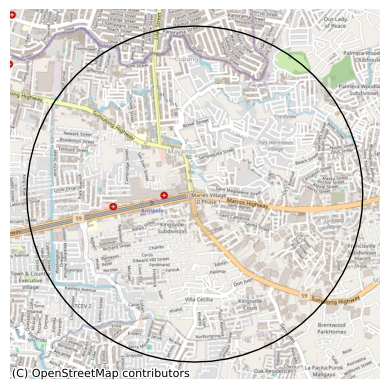

In [50]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

In [51]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [52]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [53]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([4, 1, 2, 3, 6, 5])

Examining the street intersections GDF

In [54]:
streets.head()

osmid  lanes  ref              name  \
u        v          key                                             
25353079 2001383000 0       4243609      4   59  Sumulong Highway   
         485547459  0       4243609      4   59  Sumulong Highway   
         1908173877 0    1013993994      1  NaN     Alexander III   
25353172 7348802645 0       4243609      4   59  Sumulong Highway   
         7755219331 0       4243609      4   59  Sumulong Highway   

                             highway maxspeed width  oneway reversed  length  \
u        v          key                                                        
25353079 2001383000 0        primary       50  13.2   False     True  29.567   
         485547459  0        primary       50  13.2   False    False  59.142   
         1908173877 0    residential      NaN   NaN   False     True  86.135   
25353172 7348802645 0        primary       50  13.2   False    False  16.624   
         7755219331 0        primary       50  13.2   False     True   6.273   

                                                                  geometry  \
u        v          key                                                      
25353079 2001383000 0    LINESTRING (13483562.513 1645845.693, 13483549...   
         485547459  0    LINESTRING (13483562.513 1645845.693, 13483574...   
         1908173877 0    LINESTRING (13483562.513 1645845.693, 13483548...   
25353172 7348802645 0    LINESTRING (13484238.790 1645265.119, 13484254...   
         7755219331 0    LINESTRING (13484238.790 1645265.119, 13484232...   

                          access bridge junction service tunnel  
u        v          key                                          
25353079 2001383000 0        NaN    NaN      NaN     NaN    NaN  
         485547459  0        NaN    NaN      NaN     NaN    NaN  
         1908173877 0    private    NaN      NaN     NaN    NaN  
25353172 7348802645 0        NaN    NaN      NaN     NaN    NaN  
         7755219331 0        NaN    NaN      NaN     NaN    NaN

In [55]:
intersections.head()

,y,x,street_count,highway,geometry
osmid,,,,,
25353079,14.623482,121.124903,3,NaN,POINT (13483562.513 1645845.693)
25353172,14.618436,121.130978,3,NaN,POINT (13484238.790 1645265.119)
25353345,14.625318,121.124490,4,traffic_signals,POINT (13483516.505 1646056.885)
25353355,14.619513,121.128705,4,NaN,POINT (13483985.794 1645388.998)
27143218,14.624336,121.132356,3,NaN,POINT (13484392.177 1645943.909)


Plotting the street network and intersection heatmap

In [56]:
# plt.rcParams['figure.facecolor']='black'
# plt.rcParams['savefig.facecolor']='black'

In [57]:
# bounds = buffer.to_crs("EPSG:3857").total_bounds

# fig, ax = plt.subplots(figsize=(10,10))

# fig.suptitle(
#     "Road Network",
#     y=0.09,
#     x=0.5,
#     color="white",
#     fontsize=45.0,
#     fontfamily="Garamond",
#     # transform=fig.transFigure
# )

# streets.plot(
#     color="gold",
#     lw=0.25,
#     ax=ax
# )

# buffer.to_crs("EPSG:3857").plot(
#     facecolor="none",
#     edgecolor="gold",
#     lw=0.5,
#     ax=ax
# )

# ax.hist2d(
#     intersections.geometry.x,
#     intersections.geometry.y,
#     bins=50,
#     range=np.array([(bounds[0],bounds[2]),(bounds[1],bounds[-1])]),
#     weights=intersections.street_count,
#     cmin=1.0,
#     cmap="plasma",
#     vmin=1
# )

# plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95)

# ax.set_axis_off()

# plt.margins(1)

# # fig.set_facecolor("black")
# # fig.set_edgecolor("black")

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


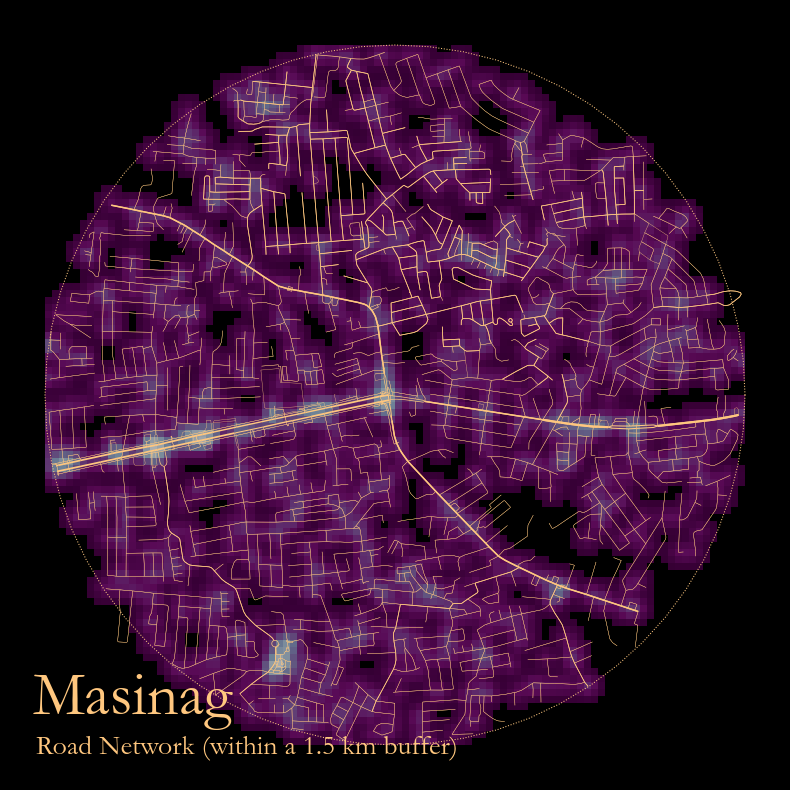

In [58]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

# print(f"axes x-limits:{ax.get_xlim()}\nbounds: {ring_bounds}")

# plt.hist2d(
#     intersections.geometry.x,
#     intersections.geometry.y,
#     bins=50,
#     range=[list(ring_bounds[0:2]), list(ring_bounds[2:])],
#     weights=intersections.street_count,
#     cmin=1.0,
#     cmap="plasma",
#     vmin=1
# )

plot_heatmap(
    intersections,
    "street_count",
    ax=ax,
    alpha=0.7,
    color_scheme="BuPu_r",
    bounds=ring_bounds
)

In [59]:
shop_pois = ox.features_from_polygon(
    buffer.geometry[0],
    {
        "shop": True,
        # "amenity": ["fast_food", "restaurant", "cafe"]
    }
)

shop_pois.shape

(140, 50)

In [60]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols, filter_elem_type

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
shop_pois = drop_nan_cols(shop_pois, 0.75)

In [61]:
shop_pois.shape

(140, 4)

In [62]:
shop_pois = shop_pois.reset_index()
shop_pois.head()

,element_type,osmid,addr:province,name,shop,geometry
0,node,696289106,Rizal,Ugat Furniture Factory,furniture,POINT (121.11236 14.62271)
1,node,696289249,Rizal,PF Trading,hardware,POINT (121.11285 14.62282)
2,node,696289272,Rizal,Searton Marketing Corp,hardware,POINT (121.11317 14.62331)
3,node,696289304,Rizal,Manila Water,utilities,POINT (121.11517 14.62278)
4,node,696289308,Rizal,Rey Home Center,hardware,POINT (121.11473 14.62273)


In [63]:
shop_pois["weight"] = 1.0

In [64]:
shop_pois = shop_pois.to_crs("EPSG:3857")

In [65]:
shop_pois["geometry"] = shop_pois["geometry"].centroid
shop_pois.shape

(140, 7)

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


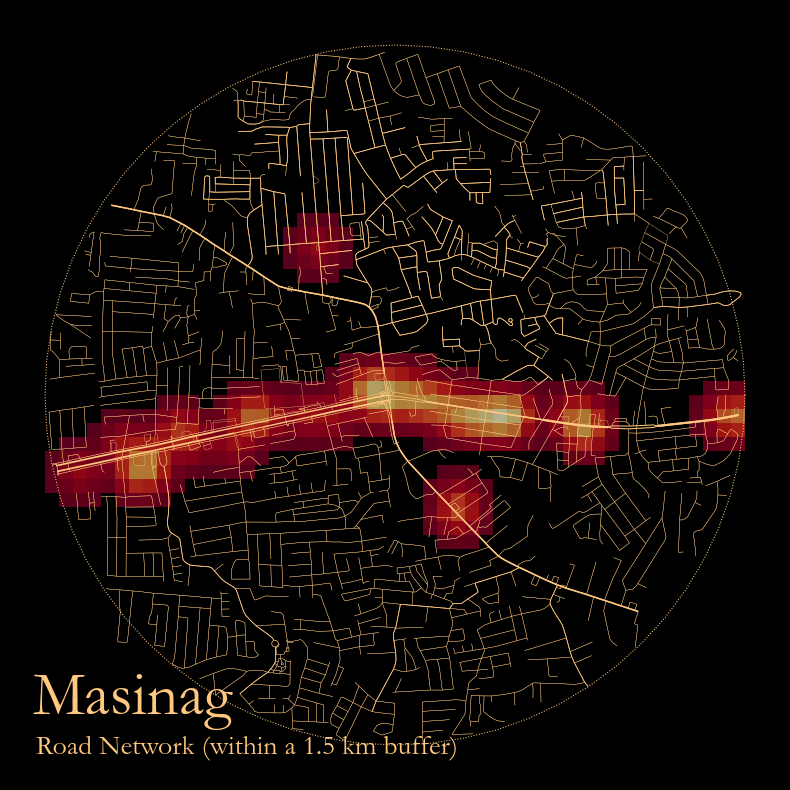

In [67]:
fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

# plt.hist2d(
#     shop_pois.geometry.x,
#     shop_pois.geometry.y,
#     bins=50,
#     range=[list(ring_bounds[0:2]), list(ring_bounds[2:])],
#     cmin=0.01,
#     cmap="plasma",
#     vmin=1
# )

plot_heatmap(
    shop_pois,
    "weight",
    bins=50,
    ax=ax,
    alpha=0.7,
    color_scheme="YlOrRd_r",
    bounds=ring_bounds
)